In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import PersLandscapeApprox
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import pandas as pd

# Create synthetic dataset 
np.random.seed(42)
cluster1 = np.random.normal(0.5, 0.05, (100, 2))
cluster2 = np.random.normal(0.6, 0.05, (100, 2))
data = np.vstack([cluster1, cluster2])
n, k = len(data), 30

# Compute kernel matrices 
pairwise_dists = squareform(pdist(data))
sigma = np.median(pairwise_dists)
K_rbf = np.exp(-pairwise_dists**2 / (2 * sigma**2))

# k-DPP sampler 
def sample_k_dpp(K, k):
    eigvals, eigvecs = eigh(K)
    eigvals = np.clip(np.real(eigvals), 0, None)
    eigvecs = np.real(eigvecs)

    idx = np.argsort(eigvals)[::-1][:k]
    V = eigvecs[:, idx]

    Y = []
    for _ in range(k):
        probs = np.sum(V**2, axis=1)
        if probs.sum() <= 1e-12:
            remaining = [i for i in range(len(K)) if i not in Y]
            Y.append(np.random.choice(remaining))
            continue
        probs = probs / probs.sum()
        i = np.random.choice(len(probs), p=probs)
        Y.append(i)

        vi = V[i, :].copy()
        if np.linalg.norm(vi) > 1e-12:
            vi = vi / np.linalg.norm(vi)
            V = V - np.outer(V @ vi, vi)
            V = V[:, np.linalg.norm(V, axis=0) > 1e-10]
    return Y

# Subset selection 
subset_random = np.random.choice(n, k, replace=False)
subset_dpp = sample_k_dpp(K_rbf, k)

In [2]:
from PLDiv import compute_PLDiv

In [ ]:
pldiv_random = compute_PLDiv(data[subset_random], hom_deg=0, sparse=None, closed_form=False)
pldiv_dpp = compute_PLDiv(data[subset_dpp], hom_deg=0, sparse=None, closed_form=False)

df = pd.DataFrame([pldiv_random, pldiv_dpp], index=["Random", "DPP"], columns=["PLDiv"])
print(df)

           PLDiv
Random  0.009231
DPP     0.017784


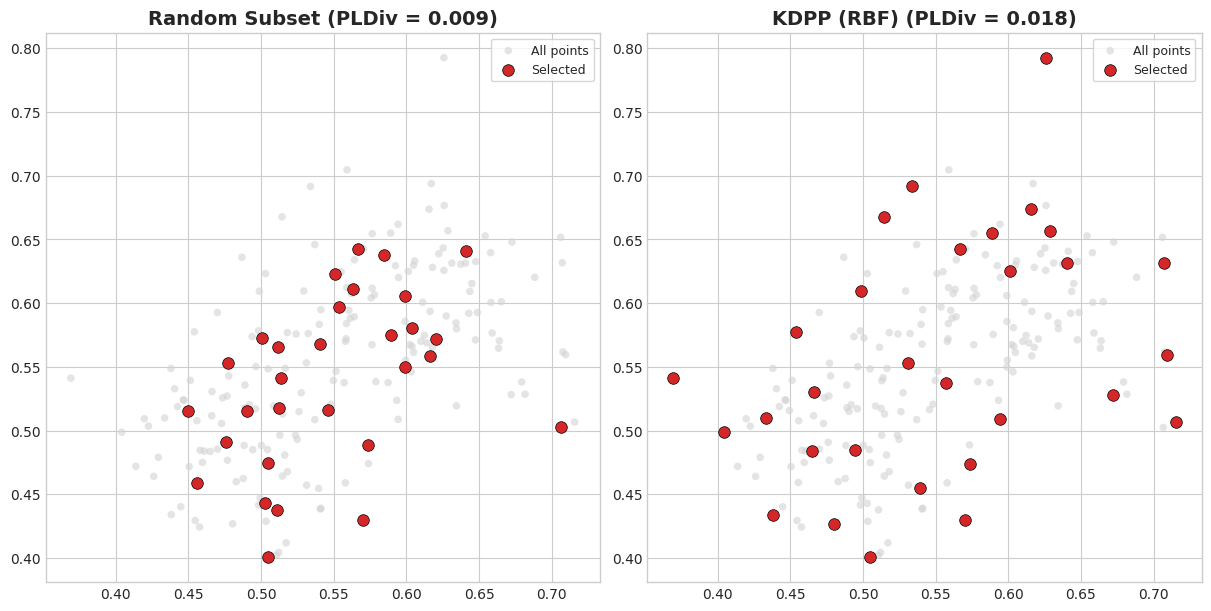

In [ ]:

plt.style.use("seaborn-v0_8-whitegrid")  # cleaner background

titles = ["Random Subset (PLDiv = 0.009)", "KDPP (RBF) (PLDiv = 0.018)"]
subsets = [subset_random, subset_dpp]


fig, axes = plt.subplots(1, len(titles), figsize=(12, 6), constrained_layout=True)

for ax, title, subset in zip(axes, titles, subsets):
    # Background points
    ax.scatter(
        data[:,0], data[:,1], 
        c="lightgray", s=30, alpha=0.6, edgecolor="none", label="All points"
    )
    
    # Highlighted subset
    ax.scatter(
        data[subset,0], data[subset,1], 
        c="#d62728", s=70, edgecolor="black", linewidth=0.5, label="Selected"
    )
    
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.legend(frameon=True, loc="best", fontsize=9)

# plt.savefig("random_kddp.png", dpi=300, bbox_inches="tight")
# plt.savefig("figure.pdf", bbox_inches="tight")  
plt.show()

In [9]:
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from vendi_score import vendi
import torch

In [11]:
sim_rbf_random = rbf_kernel(data[subset_random], gamma=0.5)
sim_l1_random = laplacian_kernel(data[subset_random], gamma = 1.0)

sim_rbf_dpp = rbf_kernel(data[subset_dpp], gamma=0.5)
sim_l1_dpp = laplacian_kernel(data[subset_dpp], gamma = 1.0)

In [16]:
def dcscore (sim_product):
    sim_product = torch.from_numpy(sim_product)
    sim_probs = sim_product.softmax(dim=-1)
    diversity = torch.sum(torch.diag(sim_probs))
    return diversity.item()

In [18]:
vs_rbf_random = vendi.score_K(sim_rbf_random)
vs_rbf_dpp = vendi.score_K(sim_rbf_dpp)

print("Vendi Scores (RBF Kernel):", vs_rbf_random, vs_rbf_dpp)

vs_l1_random = vendi.score_K(sim_l1_random)
vs_l1_dpp = vendi.score_K(sim_l1_dpp)

print("Vendi Scores (L1 Kernel):", vs_l1_random, vs_l1_dpp)

Vendi Scores (RBF Kernel): 1.0505933727590522 1.0994079677308581
Vendi Scores (L1 Kernel): 1.927974878184448 2.4181409075389872


In [19]:
dcs_rbf_random = dcscore(sim_rbf_random)
dcs_rbf_dpp = dcscore(sim_rbf_dpp)

print("DCScores (RBF Kernel):", dcs_rbf_random, dcs_rbf_dpp)

dcs_l1_random = dcscore(sim_l1_random)
dcs_l1_dpp = dcscore(sim_l1_dpp)

print("DCScores (L1 Kernel):", dcs_l1_random, dcs_l1_dpp)

DCScores (RBF Kernel): 1.0076124670881925 1.0165147131516203
DCScores (L1 Kernel): 1.1342230677474832 1.1964887187236033


In [13]:
data_mag = [data[subset_random], data[subset_dpp]]

In [ ]:
from magnipy.diversipy import Diversipy
div = Diversipy(Xs = data_mag,  ref_space=0)
mag_areas = div.MagAreas()

In [15]:
mag_areas

[np.float64(19.645376100522217), np.float64(23.340350728606083)]

Text Embeddings

In [20]:
df = pd.read_csv('data/arxiv100.csv')
df = df[:1000]
texts = df['title'].tolist()

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
data = model.encode(texts)
n = len(data)
k = 100 

np.random.seed(42)

pairwise_dists = squareform(pdist(data, metric='cosine'))

sigma = np.median(pairwise_dists)
K_rbf = np.exp(-pairwise_dists**2 / (2 * sigma**2))

def sample_k_dpp(K, k):
    eigvals, eigvecs = eigh(K)
    eigvals = np.clip(np.real(eigvals), 0, None)
    eigvecs = np.real(eigvecs)

    idx = np.argsort(eigvals)[::-1][:k]
    V = eigvecs[:, idx]

    Y = []
    for _ in range(k):
        probs = np.sum(V**2, axis=1)
        if probs.sum() <= 1e-12:
            remaining = [i for i in range(len(K)) if i not in Y]
            Y.append(np.random.choice(remaining))
            continue
        probs = probs / probs.sum()
        i = np.random.choice(len(probs), p=probs)
        Y.append(i)

        vi = V[i, :].copy()
        if np.linalg.norm(vi) > 1e-12:
            vi = vi / np.linalg.norm(vi)
            V = V - np.outer(V @ vi, vi)
            V = V[:, np.linalg.norm(V, axis=0) > 1e-10]
    return Y

dpp_indices = sample_k_dpp(K_rbf, k)
random_indices = np.random.choice(n, k, replace=False)


# Subset selection
subset_random = np.random.choice(n, k, replace=False)
subset_dpp = sample_k_dpp(K_rbf, k)


/etc/python/sitecustomize.py:117: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  mod = _original_import(name, globals, locals, fromlist, level)


In [ ]:
pldiv_random = compute_PLDiv(data[subset_random], hom_deg=0, sparse=None, closed_form=False)
pldiv_dpp = compute_PLDiv(data[subset_dpp], hom_deg=0, sparse=None, closed_form=False)

df = pd.DataFrame([pldiv_random, pldiv_dpp], index=["Random", "DPP"], columns=["PLDiv"])

In [23]:
print(df)

            PLDiv
Random  25.391584
DPP     26.620134


In [46]:
data[subset_dpp].shape

(100, 384)

In [24]:
data_mag = [data[subset_random], data[subset_dpp]]

from magnipy.diversipy import Diversipy
div = Diversipy(Xs = data_mag,  ref_space=0)
mag_areas = div.MagAreas()

mag_areas

[np.float64(40.50743112693014), np.float64(41.42186173273319)]

In [ ]:
from sklearn.preprocessing import normalize
from sklearn import preprocessing
def calculate_dcscore_by_embedding(embeddings_arr, kernel_type='cs', tau=1):
    if kernel_type == 'cs':
        # cosine similarity as teh kernel function
        embeddings_arr = preprocessing.normalize(embeddings_arr, axis=1)
        sim_product = torch.from_numpy((embeddings_arr @ embeddings_arr.T) / tau)
        sim_probs = sim_product.softmax(dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'rbf':
        sim_mat = rbf_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'lap':
        sim_mat = laplacian_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    elif kernel_type == 'poly':
        sim_mat = polynomial_kernel(embeddings_arr, embeddings_arr, tau)
        sim_probs = torch.nn.functional.softmax(torch.from_numpy(sim_mat), dim=-1)
        diversity = torch.sum(torch.diag(sim_probs))
    
    return diversity.item()

In [42]:
from vendi_score import data_utils, vendi
def embedding_vendi_score(
    X, batch_size=64, device="cpu", model=None, transform=None, normalize = True
):
    n, d = X.shape
    if n < d:
        return vendi.score_X(X, normalize = True)
    return vendi.score_dual(X, normalize = True)

In [49]:
calculate_dcscore_by_embedding(data[subset_random], kernel_type='cs', tau=1)

2.1322436332702637

In [50]:
calculate_dcscore_by_embedding(data[subset_dpp], kernel_type='cs', tau=1)

2.1853439807891846

In [35]:
embedding_vendi_score(data[subset_random])

np.float32(39.729145)

In [36]:
embedding_vendi_score(data[subset_dpp])

np.float32(43.17536)

In [25]:
sim_rbf_random = rbf_kernel(data[subset_random], gamma=0.5)
sim_l1_random = laplacian_kernel(data[subset_random], gamma = 1.0)

sim_rbf_dpp = rbf_kernel(data[subset_dpp], gamma=0.5)
sim_l1_dpp = laplacian_kernel(data[subset_dpp], gamma = 1.0)

In [26]:
vs_rbf_random = vendi.score_K(sim_rbf_random)
vs_rbf_dpp = vendi.score_K(sim_rbf_dpp)

print("Vendi Scores (RBF Kernel):", vs_rbf_random, vs_rbf_dpp)

vs_l1_random = vendi.score_K(sim_l1_random)
vs_l1_dpp = vendi.score_K(sim_l1_dpp)

print("Vendi Scores (L1 Kernel):", vs_l1_random, vs_l1_dpp)

Vendi Scores (RBF Kernel): 20.144714 21.333374
Vendi Scores (L1 Kernel): 99.99999999942868 99.99999999989453


In [27]:
dcs_rbf_random = dcscore(sim_rbf_random)
dcs_rbf_dpp = dcscore(sim_rbf_dpp)

print("DCScores (RBF Kernel):", dcs_rbf_random, dcs_rbf_dpp)

dcs_l1_random = dcscore(sim_l1_random)
dcs_l1_dpp = dcscore(sim_l1_dpp)

print("DCScores (L1 Kernel):", dcs_l1_random, dcs_l1_dpp)

DCScores (RBF Kernel): 1.6938958168029785 1.7131611108779907
DCScores (L1 Kernel): 2.6723630372344265 2.6723630628769675


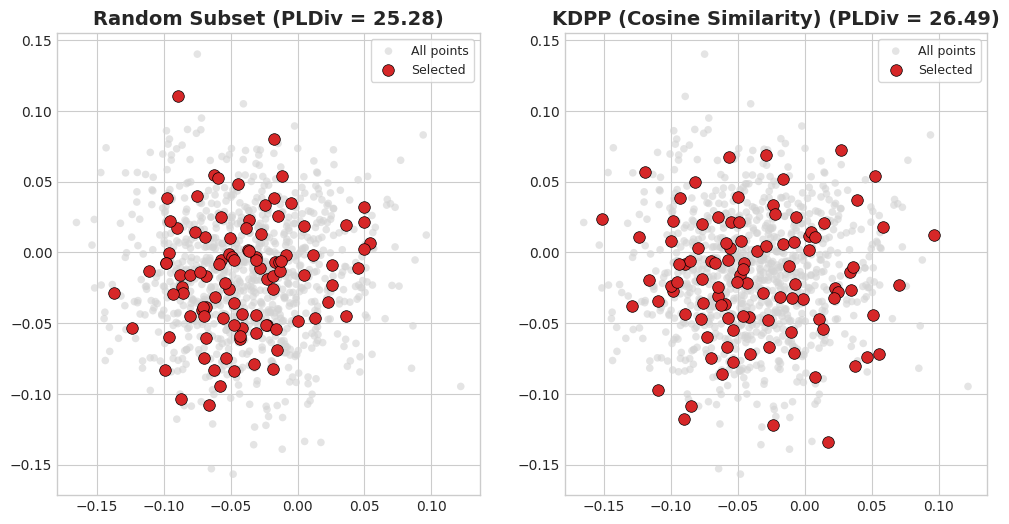

In [37]:

fig, axes = plt.subplots(1,2, figsize=(12,6))

titles = ["Random Subset (PLDiv = 25.28)", "KDPP (Cosine Similarity) (PLDiv = 26.49)"]
subsets = [subset_random, subset_dpp]

for ax, title, subset in zip(axes, titles, subsets):
    # Background points
    ax.scatter(
        data[:,0], data[:,1], 
        c="lightgray", s=30, alpha=0.6, edgecolor="none", label="All points"
    )
    
    # Highlighted subset
    ax.scatter(
        data[subset,0], data[subset,1], 
        c="#d62728", s=70, edgecolor="black", linewidth=0.5, label="Selected"
    )
    
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.legend(frameon=True, loc="best", fontsize=9)

# plt.savefig("random_kddp_cos.png", dpi=300, bbox_inches="tight")

plt.show()